## Kernel References-
### https://www.kaggle.com/vtech6/medical-masks-dataset/kernel
### https://www.kaggle.com/caglaruslu/real-time-medical-mask-detection
## Dataset References -
### https://www.kaggle.com/vtech6/medical-masks-dataset


In [ ]:
!unzip -d dataset.zip dataset

In [46]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [48]:
def getImageNames():
    
    image_names = []
    # This is the local dataset path, please provide your own path to dataset acc to your local dir
    for dirname, _, filenames in os.walk('/home/ec2-user/SageMaker/AmazonSageMaker-AmazonSageMaker-AWSChallenge-achal/medical-masks-dataset/dataset/'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml':
                image_names.append(filename)
    return image_names


def get_path(image_name):
    # This is the local dataset path, please provide your own path to dataset acc to your local dir
    home_path = '/home/ec2-user/SageMaker/AmazonSageMaker-AmazonSageMaker-AWSChallenge-achal/medical-masks-dataset/dataset/'
    image_path = home_path + 'images/' + image_name
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
    
    label_path = home_path + 'labels/' + label_name
        
    return  image_path, label_path


In [49]:
def parse_xml(label_path):

    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size


def visualize_image(image_name, bndbox=True):
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'good':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'bad':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

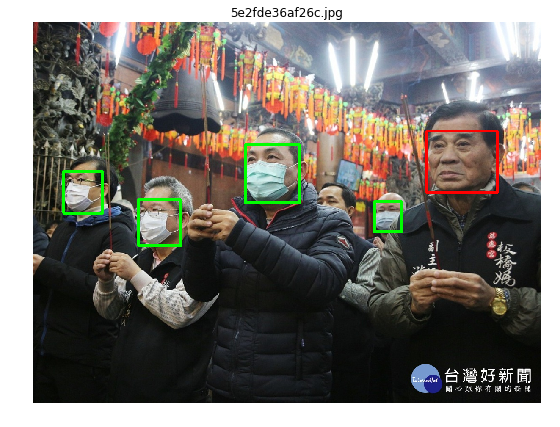

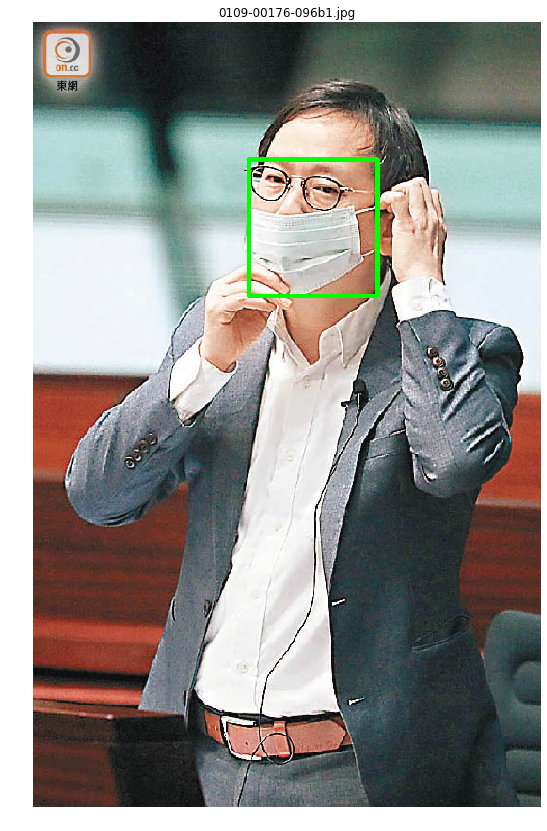

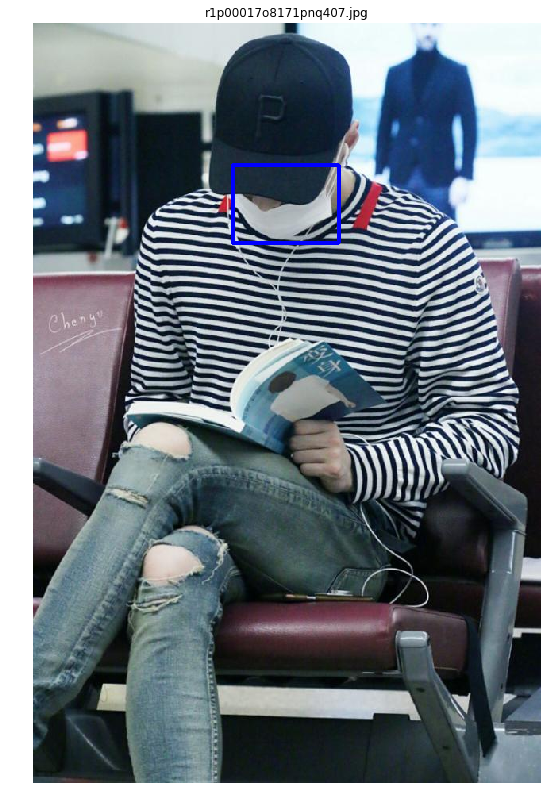

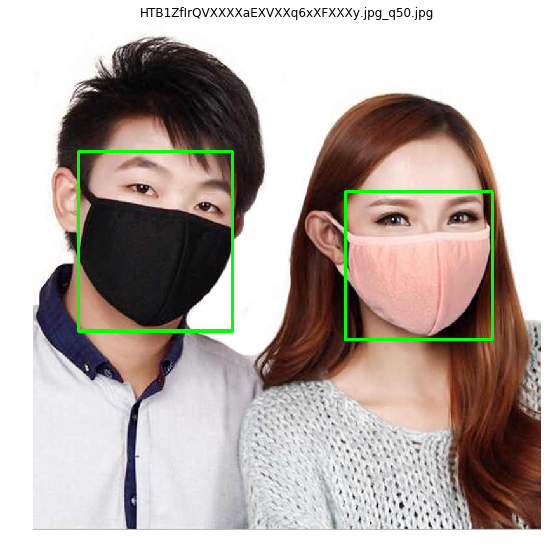

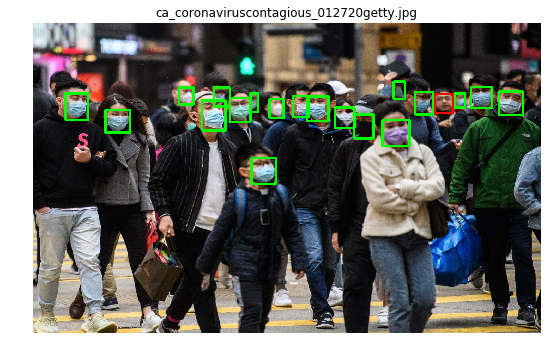

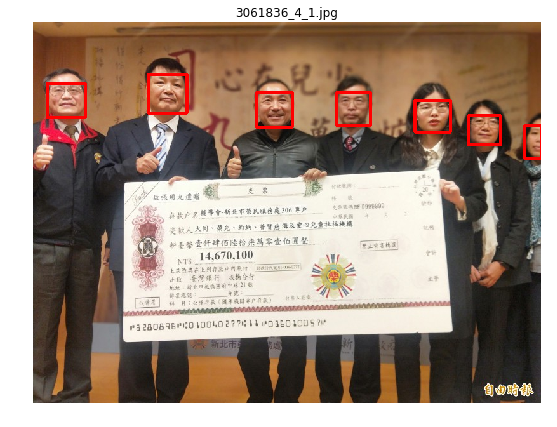

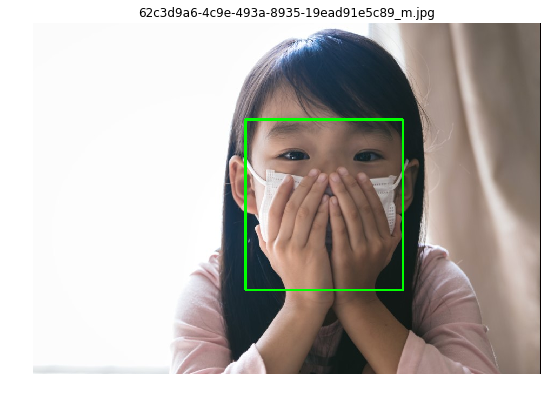

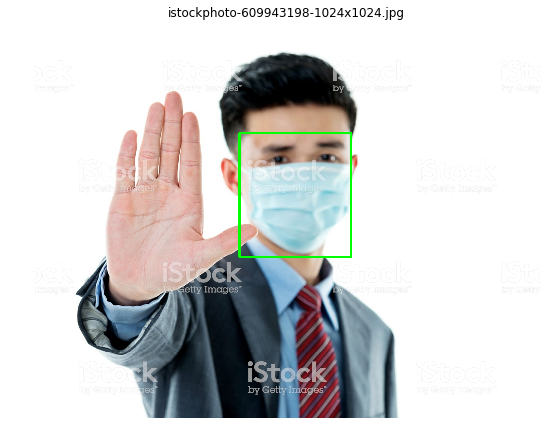

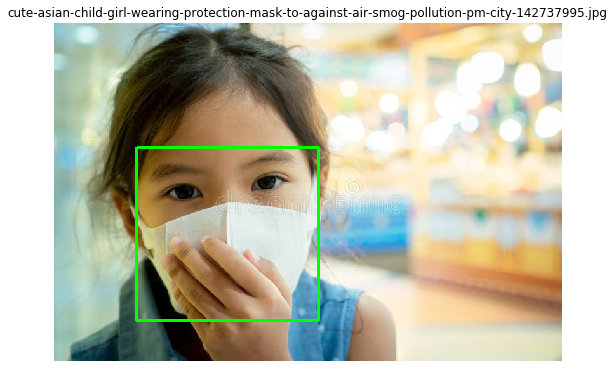

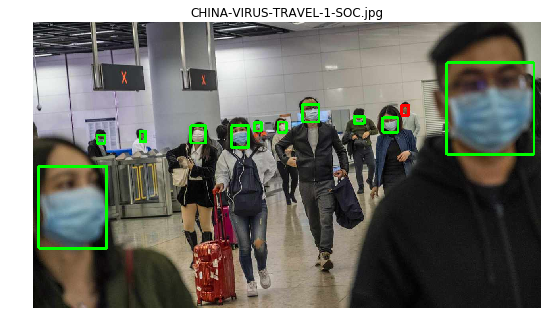

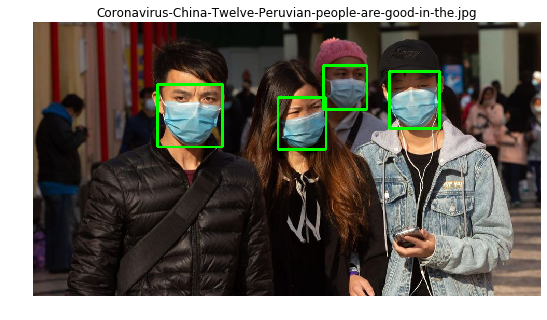

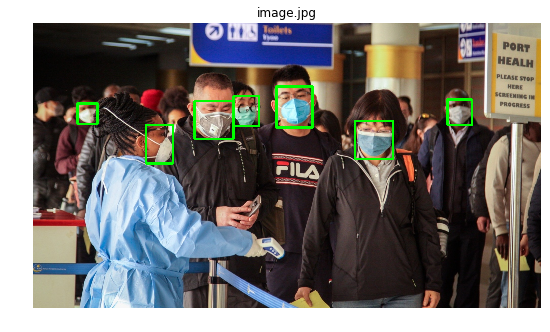

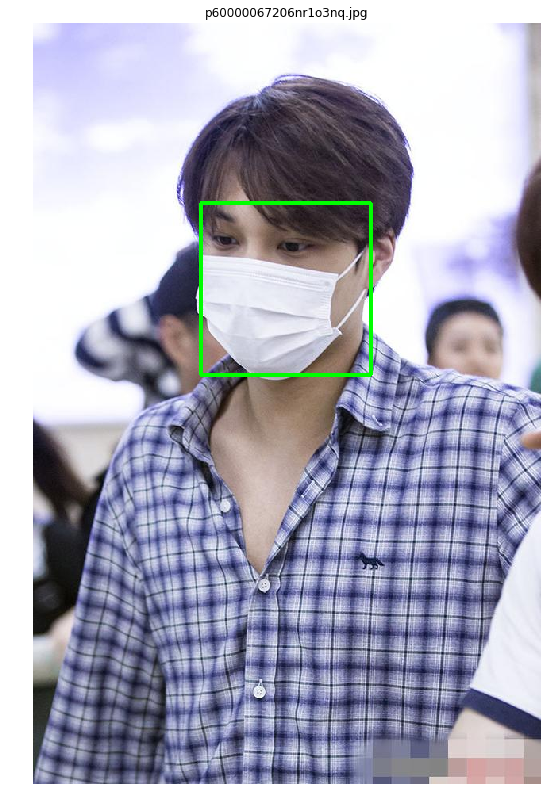

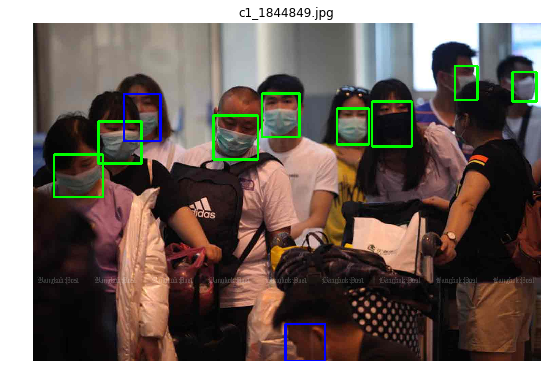

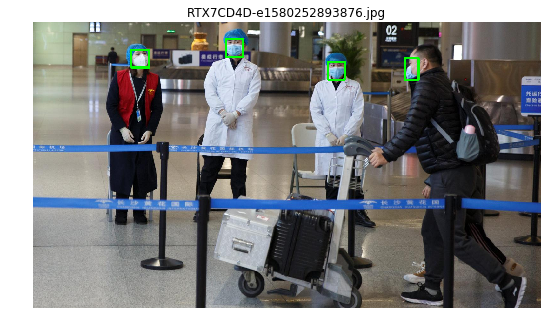

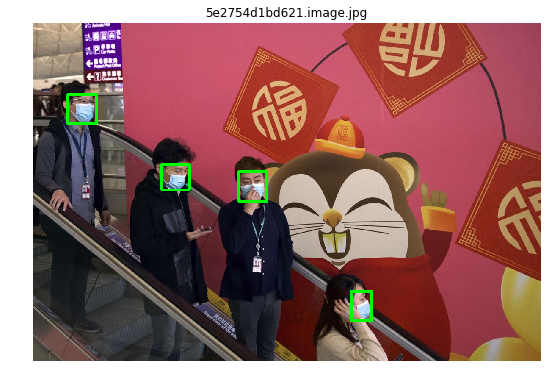

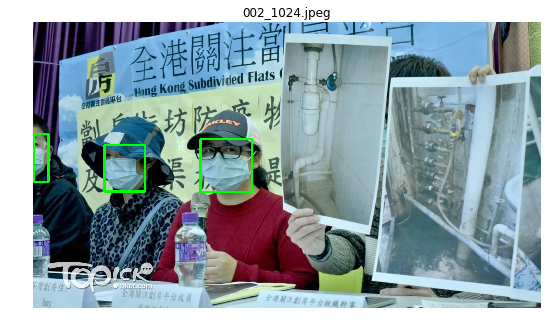

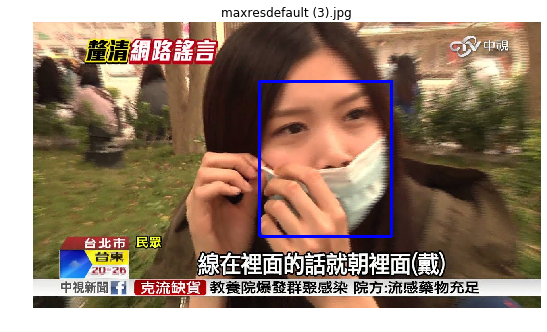

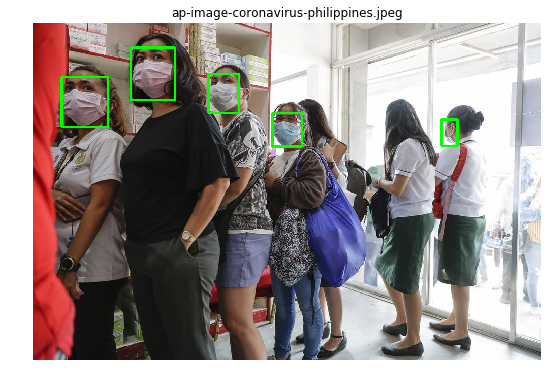

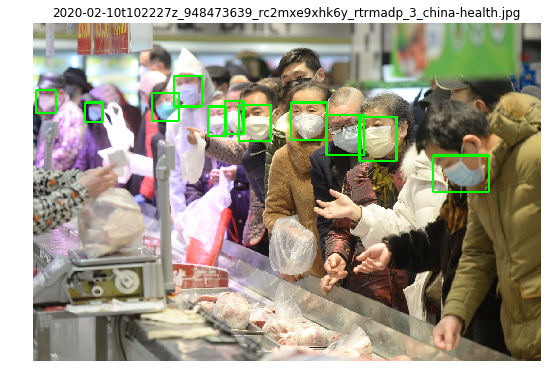

In [31]:
NUM_OF_IMGS_TO_VISUALIZE = 20

for i in range(NUM_OF_IMGS_TO_VISUALIZE):
    visualize_image(image_names[i])

In [50]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "good":
            label_num = 0
        elif name == "bad":
            label_num = 1
        else:
            label_num = 2
        
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

In [51]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [52]:
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
createDirectory(models_dir)

Directory train/ already exists.
Directory train/0/ already exists.
Directory train/1/ already exists.
Directory models/ already exists.


In [53]:
label_0_counter = 0
label_1_counter = 0


for image_name in image_names:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1
       

In [54]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]

In [55]:
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))

Total number of images: 3795
Number of images labeled 0: 3125
Number of images labeled 1: 670


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [57]:
model = models.resnet50(pretrained=True)

In [58]:
for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.LogSoftmax(dim=1))

In [59]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [60]:
dataset = datasets.ImageFolder(dir_name, transform = train_transforms)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print('Dataset size: ', len(dataset))
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(val_dataset))
print('Test set size: ', len(test_dataset))

Dataset size:  3795
Train set size:  2277
Validation set size:  759
Test set size:  759


In [61]:
BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [62]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [63]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [81]:
total_epoch = 20

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    
    for X, y in train_loader:
        
        X, y = X.cpu(), y.cpu()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            
            X, y = X.cpu(), y.cpu()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)
    
    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

EPOCH: 0 , Training Loss: 72.65125930309296 , Validation Loss: 24.150169789791107 , Accuracy:  0.7926023778071334
Model saved
EPOCH: 1 , Training Loss: 72.66718298196793 , Validation Loss: 24.137061774730682 , Accuracy:  0.7912813738441216
Model saved
EPOCH: 2 , Training Loss: 72.89677149057388 , Validation Loss: 24.16232341527939 , Accuracy:  0.7820343461030383
EPOCH: 3 , Training Loss: 72.93930065631866 , Validation Loss: 24.234450340270996 , Accuracy:  0.7727873183619551
EPOCH: 4 , Training Loss: 72.87105298042297 , Validation Loss: 23.973301112651825 , Accuracy:  0.7926023778071334
Model saved
EPOCH: 5 , Training Loss: 72.89571279287338 , Validation Loss: 24.13355815410614 , Accuracy:  0.7873183619550859
EPOCH: 6 , Training Loss: 72.4747946858406 , Validation Loss: 24.196489214897156 , Accuracy:  0.7780713342140027
EPOCH: 7 , Training Loss: 72.79578739404678 , Validation Loss: 24.164408087730408 , Accuracy:  0.7820343461030383
EPOCH: 8 , Training Loss: 72.94928503036499 , Validatio

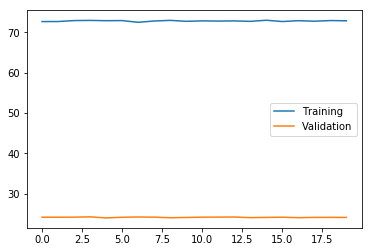

In [82]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.legend()

In [83]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

In [84]:
correct = 0
total = 0
    
with torch.no_grad():
    for X, y in test_loader:

        X, y = X.cpu(), y.cpu()

        result = loaded_model(X)
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()

accuracy = correct/total

print("\n")
print("------------")
print("Accuracy: " + str(accuracy))
print("------------")
print("\n")



------------
Accuracy: 0.8036890645586298
------------


